In [ ]:
## CPU specs ##
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2300.000
cache size	: 46080 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs
bogomips	: 4600.00
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power management:

processor	:

In [ ]:
!cat /proc/meminfo

MemTotal:       13333556 kB
MemFree:        10530824 kB
MemAvailable:   12459492 kB
Buffers:           75956 kB
Cached:          2010204 kB
SwapCached:            0 kB
Active:           735188 kB
Inactive:        1786424 kB
Active(anon):     415112 kB
Inactive(anon):      340 kB
Active(file):     320076 kB
Inactive(file):  1786084 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               168 kB
Writeback:             0 kB
AnonPages:        435560 kB
Mapped:           222136 kB
Shmem:               964 kB
Slab:             167272 kB
SReclaimable:     126800 kB
SUnreclaim:        40472 kB
KernelStack:        3584 kB
PageTables:         5504 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6666776 kB
Committed_AS:    2536576 kB
VmallocTotal:   34359738367 kB
VmallocUsed:           0 kB
VmallocChunk:          0 kB
Percpu:              920 kB
AnonHugePages:   

In [ ]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=773163a97ff7777af3a6fb216ba11b968ab46ecc1e21477514b65fa08c558918
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.7 GB  | Proc size: 160.1 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


In [1]:
# mount drive
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#############################################
## required to import custom modules in GC ##
import sys
sys.path.append('/content/drive/My Drive/PyTorchDIA - Real Image Tests')
##############################################

# grab photutils
#!pip install photutils

# other useful imports
import numpy as np
import os
import glob
from astropy.io.fits import getdata
from astropy.stats import mad_std
#from photutils import DAOStarFinder
import time
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from scipy.ndimage.interpolation import shift
from scipy.stats import norm
import PyTorchDIA_Newton
import torch
%matplotlib inline

PyTorch version: 1.5.1+cu101


In [ ]:
### pyDANDIA ###
%load_ext Cython

In [ ]:
%%cython

from __future__ import division
import numpy as np
import time
cimport numpy as np
cimport cython
DTYPE = np.float64
ctypedef np.float64_t DTYPE_t

# compile suggestion: gcc -shared -pthread -fPIC -fwrapv -O2 -Wall -fno-strict-aliasing -I/somepath/include/python2.7 -o umatrix_routine.so umatrix_routine.c

@cython.boundscheck(False) # turn off bounds-checking
@cython.wraparound(False)  # turn off negative index wrapping
@cython.nonecheck(False)  # turn off negative index wrapping

def umatrix_construction(np.ndarray[DTYPE_t, ndim = 2] reference_image,np.ndarray[DTYPE_t, ndim = 2] weights, pandq, n_kernel_np, kernel_size_np):

    cdef int ni_image = np.shape(reference_image)[0]
    cdef int nj_image = np.shape(reference_image)[1]
    cdef double sum_acc = 0.
    cdef int idx_l,idx_m,idx_l_prime,idx_m_prime,idx_i,idx_j
    cdef int kernel_size = np.int(kernel_size_np)
    cdef int kernel_size_half = np.int(kernel_size_np)/2
    cdef int n_kernel = np.int(n_kernel_np)
    cdef np.ndarray u_matrix = np.zeros([n_kernel + 1, n_kernel + 1], dtype=DTYPE)

    for idx_p in range(n_kernel):
        for idx_q in range(idx_p,n_kernel):
            sum_acc = 0.
            idx_l, idx_m = pandq[idx_p]
            idx_l_prime, idx_m_prime = pandq[idx_q]
            for idx_i in range(kernel_size_half,ni_image-kernel_size+kernel_size_half+1):
                for idx_j in range(kernel_size_half,nj_image-kernel_size+kernel_size_half+1):
                    sum_acc += reference_image[idx_i + idx_l, idx_j + idx_m] * reference_image[idx_i + idx_l_prime,idx_j + idx_m_prime]  * weights[idx_i, idx_j]
            u_matrix[idx_p, idx_q] = sum_acc
            u_matrix[idx_q, idx_p] = sum_acc

    for idx_p in [n_kernel]:
        for idx_q in range(n_kernel):
            sum_acc = 0.
            idx_l = kernel_size
            idx_m = kernel_size
            idx_l_prime, idx_m_prime = pandq[idx_q]
            for idx_i in range(kernel_size_half,ni_image-kernel_size+kernel_size_half+1):
                for idx_j in range(kernel_size_half,nj_image-kernel_size+kernel_size_half+1):
                    sum_acc += reference_image[idx_i + idx_l_prime, idx_j + idx_m_prime] * weights[idx_i, idx_j]
            u_matrix[idx_p, idx_q] = sum_acc
    
    for idx_p in range(n_kernel):
        for idx_q in [n_kernel]:
            sum_acc = 0.
            idx_l, idx_m = pandq[idx_p]
            idx_l_prime = kernel_size
            idl_m_prime = kernel_size
            for idx_i in range(kernel_size_half,ni_image-kernel_size+kernel_size_half+1):
                for idx_j in range(kernel_size_half, nj_image-kernel_size+kernel_size_half+1):
                    sum_acc += reference_image[idx_i + idx_l, idx_j + idx_m] * weights[idx_i, idx_j] 
            u_matrix[idx_p, idx_q] = sum_acc

    sum_acc = 0.
    for idx_i in range(ni_image):
        for idx_j in range(nj_image):
            sum_acc += weights[idx_i, idx_j] 
    u_matrix[n_kernel, n_kernel] = sum_acc
    
    return u_matrix

def bvector_construction(np.ndarray[DTYPE_t, ndim = 2] reference_image,np.ndarray[DTYPE_t, ndim = 2] data_image,np.ndarray[DTYPE_t, ndim = 2] weights, pandq, n_kernel_np, kernel_size_np):

    cdef int ni_image = np.shape(data_image)[0]
    cdef int nj_image = np.shape(data_image)[1]
    cdef double sum_acc = 0.
    cdef int idx_l,idx_m,idx_l_prime,idx_m_prime,idx_i,idx_j
    cdef int kernel_size = np.int(kernel_size_np)
    cdef int kernel_size_half = np.int(kernel_size_np)/2
    cdef int n_kernel = np.int(n_kernel_np)
        
    cdef np.ndarray b_vector = np.zeros([n_kernel + 1], dtype=DTYPE)
    for idx_p in range(n_kernel):
        idx_l, idx_m = pandq[idx_p]
        sum_acc = 0.
        for idx_i in range(kernel_size_half,ni_image-kernel_size+kernel_size_half+1):
            for idx_j in range(kernel_size_half,nj_image-kernel_size+kernel_size_half+1):
                   sum_acc += data_image[idx_i, idx_j] * reference_image[idx_i + idx_l , idx_j + idx_m ] * weights[idx_i, idx_j]
        b_vector[idx_p] = sum_acc

    sum_acc = 0.
    for idx_i in range(ni_image):
        for idx_j in range(nj_image):
            sum_acc += data_image[idx_i, idx_j] * weights[idx_i, idx_j]
    b_vector[n_kernel] = sum_acc

    return b_vector


## Specify all the functions required ##

def extend_image(image, kernel_size):
    image_extended = np.zeros((np.shape(image)[0] + 2 * kernel_size,
                             np.shape(image)[1] + 2 * kernel_size))
    image_extended[kernel_size:-kernel_size, kernel_size:-kernel_size] = np.array(image, float)
    
    return image_extended

# function to build the kernel, U matrix and b vector
def construct_kernel_and_matrices(kernel_size, R, I, weights):

    pandq = []
    n_kernel = kernel_size * kernel_size
    ncount = 0
    half_kernel_size = int(int(kernel_size) / 2)
    for lidx in range(kernel_size):
        for midx in range(kernel_size):
            pandq.append((lidx - half_kernel_size, midx - half_kernel_size))


    R = R.astype('float64')
    I =  I.astype('float64')
    weights = weights.astype('float64')

    start_time = time.time()
    U = umatrix_construction(R, weights, pandq, n_kernel, kernel_size)
    b = bvector_construction(R, I, weights, pandq, n_kernel, kernel_size)
    print("--- Finished U and b construction in %s seconds ---" % (time.time() - start_time))
    return U, b


# define a function for the least-squares solution
def lstsq_solution(R, I, U, b, kernel_size):
    
    lstsq_result = np.linalg.lstsq(np.array(U), np.array(b), rcond=None)
    a_vector = lstsq_result[0]
    lstsq_fit = np.dot(np.array(U), a_vector)
    resid = np.array(b) - lstsq_fit
    reduced_chisqr = np.sum(resid ** 2) / (float(kernel_size * kernel_size))
    lstsq_cov = np.dot(np.array(U).T, np.array(U)) * reduced_chisqr
    resivar = np.var(resid, ddof=0) * float(len(a_vector))
    
    # use pinv in order to stabilize calculation
    a_var = np.diag(np.linalg.pinv(lstsq_cov) * resivar)

    a_vector_err = np.sqrt(a_var)
    output_kernel = np.zeros(kernel_size * kernel_size, dtype=float)
    if len(a_vector) > kernel_size * kernel_size:
        output_kernel = a_vector[:-1]
    else:
        output_kernel = a_vector
    output_kernel = output_kernel.reshape((kernel_size, kernel_size))

    err_kernel = np.zeros(kernel_size * kernel_size, dtype=float)
    if len(a_vector) > kernel_size * kernel_size:
        err_kernel = a_vector_err[:-1]
        err_kernel = err_kernel.reshape((kernel_size, kernel_size))
    else:
        err_kernel = a_vector_err
        err_kernel = err_kernel.reshape((kernel_size, kernel_size))

    output_kernel_2 = np.flip(np.flip(output_kernel, 0), 1)
    err_kernel_2 = np.flip(np.flip(err_kernel, 0), 1)
    bkg_kernel = a_vector[-1]
    output_kernel_2.shape

    return output_kernel_2, bkg_kernel

In [ ]:
## load images, reference and master flat ##
## this can take a while in colab

## path to images
path = '/content/drive/My Drive/PyTorchDIA - Real Image Tests/LOB190560Z'

## reference
ref_file = os.path.join(path, 'coll_LOB190560Z_Llr_2019-05-14_00129.fits')
ref_data = getdata(ref_file, header=True)
ref, ref_fwhm = ref_data[0], ref_data[1]['FWHM']
print(ref_fwhm)

## master flat
flat_file = os.path.join(path, 'master_flat.fits')
master_flat = getdata(flat_file, 0, header=True)[0]

## shifts
shift_info = os.path.join(path, 'Shift_info.txt')
shifts = np.genfromtxt(shift_info, delimiter="\t", dtype=str) # filename | xs | ys

## crop reference and master flat ##
crop = 15
ref = ref[crop:ref.shape[0]-crop, crop:ref.shape[1]-crop]
#master_flat = master_flat[crop:master_flat.shape[0]-crop, crop:master_flat.shape[1]-crop]


## ensure dtype=np.float32
ref = np.array(ref, dtype=np.float32)
master_flat = np.array(master_flat, dtype=np.float32)

fnames = []
images = []
FWHMs = []
N_images = []

for image_file in glob.glob(os.path.join(path, "*coll*")):
  # avoid reference
  if ref_file not in image_file:
    fnames.append(image_file.split('/')[-1])
    print(image_file.split('/')[-1])
    image_data = getdata(image_file, header=True)
    image, header = image_data[0], image_data[1]
    image = image[crop:image.shape[0]-crop, crop:image.shape[1]-crop]
    ## apply any crops to image border ##
    images.append(image)
    FWHMs.append(header['FWHM'])
    N_images.append(header['TOT_IM'])

# convert to numpy arrays (float32)
images, FWHMs = np.array(images, dtype=np.float32), np.array(FWHMs)

print(ref.shape, master_flat.shape, images.shape)
print('Max x shift:', np.max(shifts[:,2].astype(float)))
print('Max y shift:', np.max(shifts[:,1].astype(float)))
print(np.median(FWHMs))

4.292310021996962
coll_LOB190560Z_Llr_2019-05-15_00099.fits
coll_LOB190560Z_Llr_2019-05-12_00055.fits
coll_LOB190560Z_Llr_2019-05-13_00098.fits
coll_LOB190560Z_Llr_2019-05-16_00078.fits
coll_LOB190560Z_Llr_2019-05-14_00100.fits
coll_LOB190560Z_Llr_2019-05-15_00002.fits
coll_LOB190560Z_Llr_2019-05-15_00089.fits
coll_LOB190560Z_Llr_2019-05-12_00029.fits
coll_LOB190560Z_Llr_2019-05-12_00078.fits
coll_LOB190560Z_Llr_2019-05-15_00116.fits
coll_LOB190560Z_Llr_2019-05-14_00069.fits
coll_LOB190560Z_Llr_2019-05-15_00111.fits
coll_LOB190560Z_Llr_2019-05-15_00035.fits
coll_LOB190560Z_Llr_2019-05-15_00087.fits
coll_LOB190560Z_Llr_2019-05-15_00041.fits
coll_LOB190560Z_Llr_2019-05-12_00058.fits
coll_LOB190560Z_Llr_2019-05-10_00108.fits
coll_LOB190560Z_Llr_2019-05-15_00039.fits
coll_LOB190560Z_Llr_2019-05-14_00121.fits
coll_LOB190560Z_Llr_2019-05-14_00112.fits
coll_LOB190560Z_Llr_2019-05-14_00187.fits
coll_LOB190560Z_Llr_2019-05-12_00059.fits
coll_LOB190560Z_Llr_2019-05-14_00192.fits
coll_LOB190560Z_

Image 0 of 158
FWHM: 7.208181909203837
N images: 1200.0
Aligning flat with (xs, ys) shifts: 1 3

Sample: 0
Not subtracting sky prior to kernel solution
Ignoring read noise...
--- Time to move data onto GPU: 0.0011935234069824219 ---
Convergence reached!
--- Finished kernel and background fit in 3.9012999534606934 seconds ---
Parameter containing:
tensor([[2721.1221, -132.2156,   -5.2842,  196.2215,   80.1928, 1172.5796,
            8.7676]], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0214, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2721.1220703125
Ignoring read noise...
Sum abs(norm_resids): 215922.61079535392

Number of masked pixels: 592.0


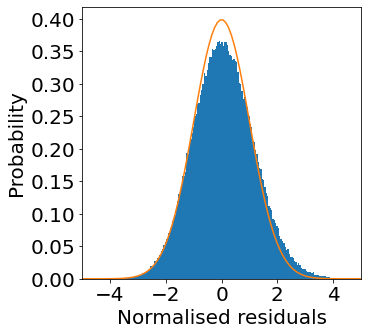

Convergence reached!
--- Finished kernel and background fit in 3.882484197616577 seconds ---
Parameter containing:
tensor([[2735.2134, -130.8268,  -12.5969,  248.9020,  154.2953, 1148.1105,
           57.4648]], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0126, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2735.21337890625
Ignoring read noise...
Sum abs(norm_resids): 214664.90391707662

Number of masked pixels: 595.0


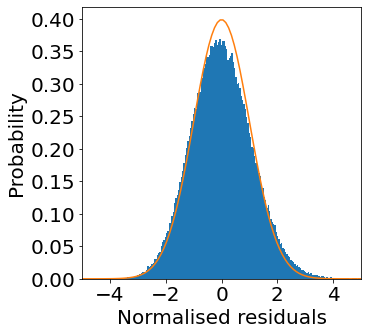

Decreasing SD learning rate to default for Adam: 1e-3
Switching to Qausi-Newton step
Convergence reached!
--- Finished kernel and background fit in 1.1216461658477783 seconds ---
Parameter containing:
tensor([[2735.2134, -130.8287,  -12.5971,  248.9020,  154.2954, 1148.1091,
           57.4647]], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0125, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2735.21337890625
Photometric Scale Factor: 1.0125194
Converged in 3 iterations
--- Finished in a total of 16.015867233276367 seconds ---
SNR: 1050.3874176391807
Image 1 of 158
FWHM: 8.237368801564449
N images: 1200.0
Aligning flat with (xs, ys) shifts: -1 -3

Sample: 0
Not subtracting sky prior to kernel solution
Ignoring read noise...
--- Time to move data onto GPU: 0.001169443130493164 ---
Switching to Qausi-Newton step
Convergence reached!
--- Finished kernel and background fit in 2.7766671180725098 seconds ---
Parameter containing:
tensor([[2231.5820,  -90.0026, -159.4438,

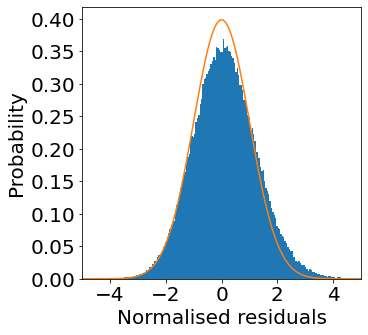

Switching to Qausi-Newton step
Convergence reached!
--- Finished kernel and background fit in 3.399183750152588 seconds ---
Parameter containing:
tensor([[2260.3911,  -95.4811, -160.5480,  226.1852,  553.6879,  687.1173,
          843.6505]], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9793, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2260.39111328125
Ignoring read noise...
Sum abs(norm_resids): 210274.76889623527

Number of masked pixels: 269.0


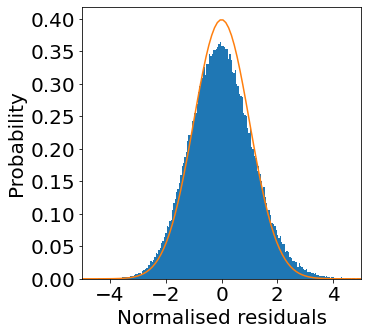

Decreasing SD learning rate to default for Adam: 1e-3
Switching to Qausi-Newton step
Convergence reached!
--- Finished kernel and background fit in 1.5240802764892578 seconds ---
Parameter containing:
tensor([[2260.3967,  -95.4832, -160.5487,  226.1910,  553.6900,  687.1161,
          843.6503]], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9793, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2260.396728515625
Photometric Scale Factor: 0.97926337
Converged in 3 iterations
--- Finished in a total of 10.495011329650879 seconds ---
SNR: 1016.6672997405574
Image 2 of 158
FWHM: 6.610971295785458
N images: 1200.0
Aligning flat with (xs, ys) shifts: 3 13

Sample: 0
Not subtracting sky prior to kernel solution
Ignoring read noise...
--- Time to move data onto GPU: 0.0010669231414794922 ---
Switching to Qausi-Newton step
Convergence reached!
--- Finished kernel and background fit in 4.167065382003784 seconds ---
Parameter containing:
tensor([[2327.3525,   29.7369,   34.5596

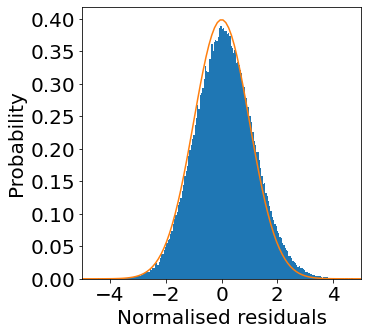

Switching to Qausi-Newton step
Convergence reached!
--- Finished kernel and background fit in 3.53300404548645 seconds ---
Parameter containing:
tensor([[2350.7764,   23.6657,   33.1225, -146.1367,  -93.2325, -510.4908,
         -621.6255]], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9229, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2350.7763671875
Ignoring read noise...
Sum abs(norm_resids): 196142.73493642412

Number of masked pixels: 160.0


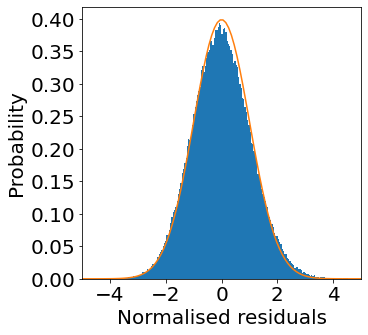

Decreasing SD learning rate to default for Adam: 1e-3
Convergence reached!
--- Finished kernel and background fit in 3.985548496246338 seconds ---
Parameter containing:
tensor([[2350.7761,   23.6222,   33.1367, -146.1378,  -93.2398, -510.5245,
         -621.5811]], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9229, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2350.776123046875
Photometric Scale Factor: 0.92286897
Converged in 3 iterations
--- Finished in a total of 14.250398874282837 seconds ---
SNR: 1024.2168285021432
Image 3 of 158
FWHM: 9.629508459320077
N images: 1200.0
Aligning flat with (xs, ys) shifts: -1 -4

Sample: 0
Not subtracting sky prior to kernel solution
Ignoring read noise...
--- Time to move data onto GPU: 0.001154184341430664 ---
Convergence reached!
--- Finished kernel and background fit in 3.8789021968841553 seconds ---
Parameter containing:
tensor([[2993.9526,   -8.4813, -157.9472,   13.9597,  513.1757,   -5.7759,
          -29.4696]], devic

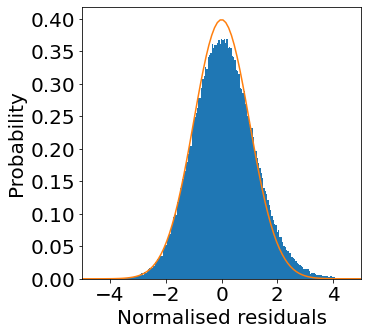

Convergence reached!
--- Finished kernel and background fit in 4.087275266647339 seconds ---
Parameter containing:
tensor([[3016.6270,  -12.9868, -162.0056,   23.9739,  529.0378,    4.2844,
           36.7785]], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.7844, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 3016.626953125
Ignoring read noise...
Sum abs(norm_resids): 203290.93404464147

Number of masked pixels: 207.0


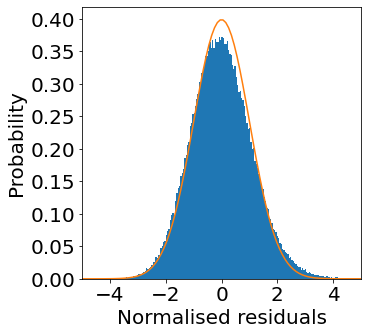

Decreasing SD learning rate to default for Adam: 1e-3
Switching to Qausi-Newton step
Convergence reached!
--- Finished kernel and background fit in 1.5011389255523682 seconds ---
Parameter containing:
tensor([[3016.6270,  -12.9847, -162.0031,   23.9708,  529.0368,    4.2858,
           36.7811]], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.7844, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 3016.626953125
Photometric Scale Factor: 0.7843584
Converged in 3 iterations
--- Finished in a total of 11.607330322265625 seconds ---
SNR: 698.7021600772835
Image 4 of 158
FWHM: 6.128724846985156
N images: 1200.0
Aligning flat with (xs, ys) shifts: 1 6

Sample: 0
Not subtracting sky prior to kernel solution
Ignoring read noise...
--- Time to move data onto GPU: 0.0012843608856201172 ---
Convergence reached!
--- Finished kernel and background fit in 4.145634412765503 seconds ---
Parameter containing:
tensor([[ 2.4422e+03,  1.7875e+00, -1.8493e+01, -6.4549e+01, -7.5607e+01,
   

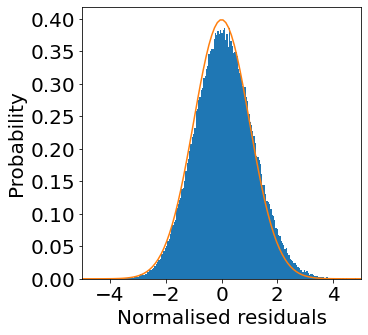

Convergence reached!
--- Finished kernel and background fit in 4.087646484375 seconds ---
Parameter containing:
tensor([[ 2.4646e+03, -7.4416e-01, -1.8762e+01, -5.9739e+01, -5.8546e+01,
         -2.3898e+02, -2.4529e+02]], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9518, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2464.61279296875
Ignoring read noise...
Sum abs(norm_resids): 194571.5331406894

Number of masked pixels: 80.0


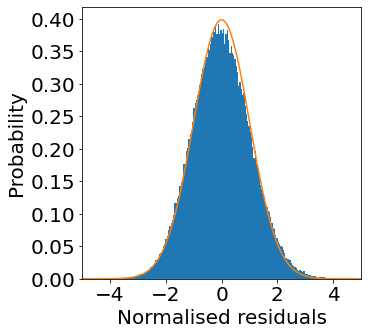

Decreasing SD learning rate to default for Adam: 1e-3
Convergence reached!
--- Finished kernel and background fit in 4.235301494598389 seconds ---
Parameter containing:
tensor([[ 2.4646e+03, -7.4880e-01, -1.8767e+01, -5.9742e+01, -5.8546e+01,
         -2.3899e+02, -2.4529e+02]], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9517, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2464.61279296875
Photometric Scale Factor: 0.95169514
Converged in 3 iterations
--- Finished in a total of 14.96268892288208 seconds ---
SNR: 1046.5166845948181
Image 5 of 158
FWHM: 9.784816284668382
N images: 1200.0
Aligning flat with (xs, ys) shifts: 4 9

Sample: 0
Not subtracting sky prior to kernel solution
Ignoring read noise...
--- Time to move data onto GPU: 0.0013129711151123047 ---
Switching to Qausi-Newton step
Convergence reached!
--- Finished kernel and background fit in 4.631199836730957 seconds ---
Parameter containing:
tensor([[2729.5508,  -47.7768,   13.6924,  -57.6383,  -27.443

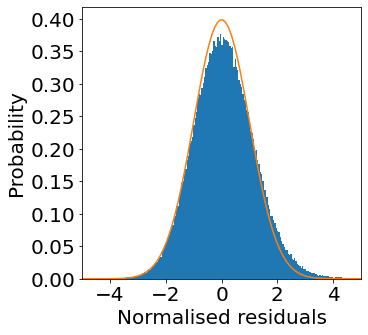

Convergence reached!
--- Finished kernel and background fit in 4.132333278656006 seconds ---
Parameter containing:
tensor([[ 2.7462e+03, -5.0616e+01, -5.2265e-01, -2.1243e+01,  1.5119e+01,
         -2.6752e+01, -6.2223e+02]], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.8756, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2746.18408203125
Ignoring read noise...
Sum abs(norm_resids): 208118.45412586478

Number of masked pixels: 686.0


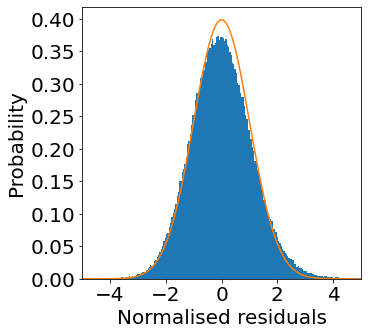

Decreasing SD learning rate to default for Adam: 1e-3
Convergence reached!
--- Finished kernel and background fit in 3.933539628982544 seconds ---
Parameter containing:
tensor([[ 2.7462e+03, -5.0581e+01, -5.4700e-01, -2.1239e+01,  1.5137e+01,
         -2.6736e+01, -6.2223e+02]], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.8753, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2746.18701171875
Photometric Scale Factor: 0.87527347
Converged in 3 iterations
--- Finished in a total of 16.22789192199707 seconds ---
SNR: 841.0536520532638
Image 6 of 158
FWHM: 7.581018581193582
N images: 1200.0
Aligning flat with (xs, ys) shifts: 6 4

Sample: 0
Not subtracting sky prior to kernel solution
Ignoring read noise...
--- Time to move data onto GPU: 0.0012362003326416016 ---
Convergence reached!
--- Finished kernel and background fit in 4.120440483093262 seconds ---
Parameter containing:
tensor([[2906.4167, -123.6265,   -4.8971,  183.0324,  187.3861, 1023.8433,
          102.2120

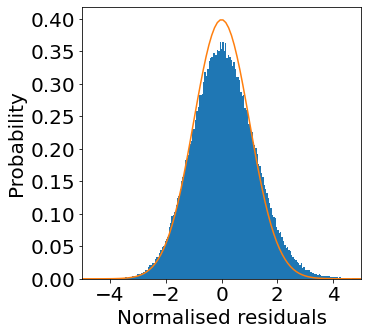

Convergence reached!
--- Finished kernel and background fit in 4.108323812484741 seconds ---
Parameter containing:
tensor([[2919.4170, -121.7449,  -18.6139,  243.3468,  271.2696,  997.6613,
          207.4952]], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0121, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2919.4169921875
Ignoring read noise...
Sum abs(norm_resids): 219555.73613095397

Number of masked pixels: 675.0


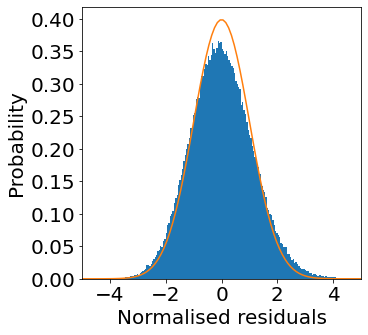

Decreasing SD learning rate to default for Adam: 1e-3
Convergence reached!
--- Finished kernel and background fit in 3.9560866355895996 seconds ---
Parameter containing:
tensor([[2919.5042, -122.0003,  -18.6490,  243.4382,  271.3376,  997.3876,
          207.4742]], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0118, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2919.504150390625
Photometric Scale Factor: 1.0118419
Converged in 3 iterations
--- Finished in a total of 18.0659761428833 seconds ---
SNR: 986.6278759931508
Image 7 of 158
FWHM: 5.923022577920849
N images: 1200.0
Aligning flat with (xs, ys) shifts: 4 5

Sample: 0
Not subtracting sky prior to kernel solution
Ignoring read noise...
--- Time to move data onto GPU: 0.001341104507446289 ---
Switching to Qausi-Newton step
Convergence reached!
--- Finished kernel and background fit in 4.206939697265625 seconds ---
Parameter containing:
tensor([[2262.2939,  -47.5473,  -31.1837,   49.3178,  225.2075,  129.3185,
  

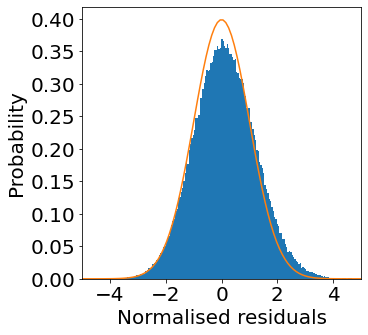

Convergence reached!
--- Finished kernel and background fit in 3.908290147781372 seconds ---
Parameter containing:
tensor([[2290.3120,  -50.2296,  -30.7055,   41.8976,  226.0253,  130.4904,
          407.5760]], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9892, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2290.31201171875
Ignoring read noise...
Sum abs(norm_resids): 205826.71084516548

Number of masked pixels: 162.0


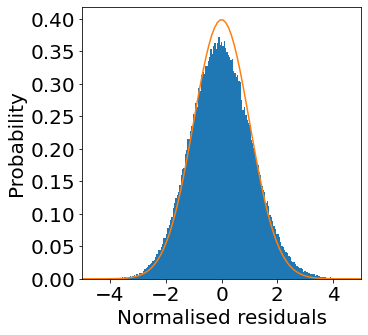

Decreasing SD learning rate to default for Adam: 1e-3
Switching to Qausi-Newton step
Convergence reached!
--- Finished kernel and background fit in 1.176168441772461 seconds ---
Parameter containing:
tensor([[2290.3120,  -50.2292,  -30.7043,   41.8965,  226.0275,  130.4933,
          407.5797]], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9892, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2290.31201171875
Photometric Scale Factor: 0.9892139
Converged in 3 iterations
--- Finished in a total of 12.223258256912231 seconds ---
SNR: 1112.09665334451
Image 8 of 158
FWHM: 7.470050458925156
N images: 1200.0
Aligning flat with (xs, ys) shifts: 5 8

Sample: 0
Not subtracting sky prior to kernel solution
Ignoring read noise...
--- Time to move data onto GPU: 0.0012629032135009766 ---
Switching to Qausi-Newton step
Convergence reached!
--- Finished kernel and background fit in 3.8657593727111816 seconds ---
Parameter containing:
tensor([[2356.2671,  -59.8196,  -26.2055,  10

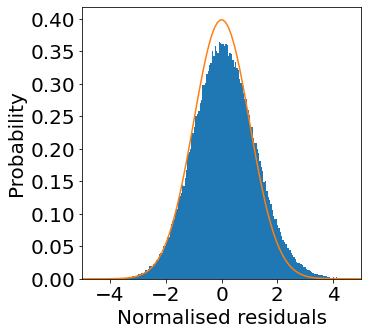

Switching to Qausi-Newton step
Convergence reached!
--- Finished kernel and background fit in 4.066168785095215 seconds ---
Parameter containing:
tensor([[2384.2900,  -65.2270,  -29.5016,   94.8040,  284.3855,  308.6565,
          337.0445]], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9784, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2384.2900390625
Ignoring read noise...
Sum abs(norm_resids): 208015.96132469526

Number of masked pixels: 295.0


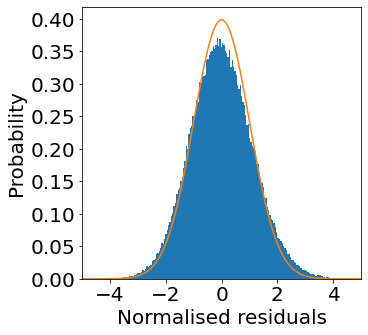

Decreasing SD learning rate to default for Adam: 1e-3
Switching to Qausi-Newton step
Convergence reached!
--- Finished kernel and background fit in 1.9729623794555664 seconds ---
Parameter containing:
tensor([[2384.2903,  -65.2325,  -29.4974,   94.8037,  284.3859,  308.6500,
          337.0509]], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9788, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2384.290283203125
Photometric Scale Factor: 0.9787512
Converged in 3 iterations
--- Finished in a total of 13.204087495803833 seconds ---
SNR: 1023.0742792217112
Image 9 of 158
FWHM: 9.053990046317159
N images: 1200.0
Aligning flat with (xs, ys) shifts: 5 2

Sample: 0
Not subtracting sky prior to kernel solution
Ignoring read noise...
--- Time to move data onto GPU: 0.0010769367218017578 ---
Convergence reached!
--- Finished kernel and background fit in 3.8592257499694824 seconds ---
Parameter containing:
tensor([[2849.7275,  -60.3908,  -27.3670,  -67.2147,  156.0993,  243.882

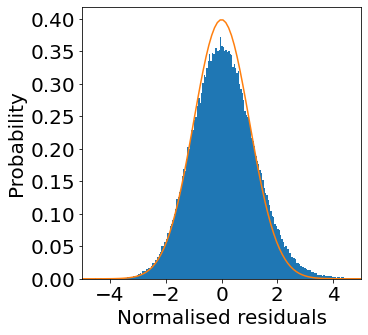

Convergence reached!
--- Finished kernel and background fit in 3.8804447650909424 seconds ---
Parameter containing:
tensor([[2859.4084,  -57.7873,  -44.0785,    8.0801,  248.7056,  206.1709,
          156.5579]], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9453, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2859.408447265625
Ignoring read noise...
Sum abs(norm_resids): 222627.4868797262

Number of masked pixels: 881.0


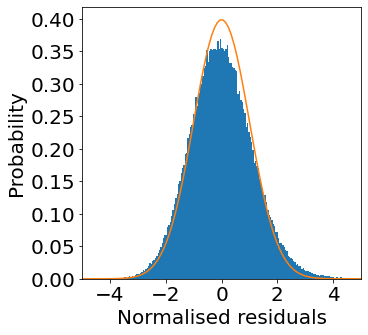

Decreasing SD learning rate to default for Adam: 1e-3
Switching to Qausi-Newton step
Convergence reached!
--- Finished kernel and background fit in 2.2113864421844482 seconds ---
Parameter containing:
tensor([[2859.4102,  -57.7897,  -44.0785,    8.0803,  248.7077,  206.1692,
          156.5581]], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9451, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2859.41015625
Photometric Scale Factor: 0.94510263
Converged in 3 iterations
--- Finished in a total of 16.011094093322754 seconds ---
SNR: 918.7448061247122
Image 10 of 158
FWHM: 7.119017144003217
N images: 1200.0
Aligning flat with (xs, ys) shifts: -5 5

Sample: 0
Not subtracting sky prior to kernel solution
Ignoring read noise...
--- Time to move data onto GPU: 0.0012927055358886719 ---
Convergence reached!
--- Finished kernel and background fit in 4.09342622756958 seconds ---
Parameter containing:
tensor([[2550.2212,    8.6045, -107.9141,  -77.4984,  120.4596, -278.8316,
 

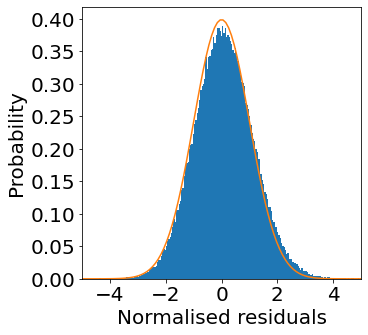

Convergence reached!
--- Finished kernel and background fit in 4.561824560165405 seconds ---
Parameter containing:
tensor([[2572.3831,    4.1418, -110.9063,  -71.1276,  129.5616, -267.7936,
          129.4761]], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9294, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2572.383056640625
Ignoring read noise...
Sum abs(norm_resids): 195613.86633583554

Number of masked pixels: 236.0


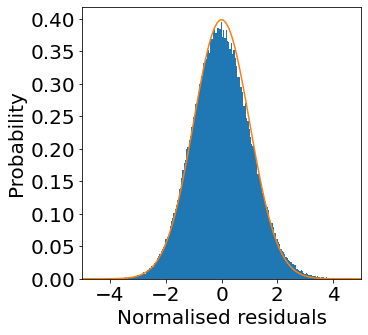

Decreasing SD learning rate to default for Adam: 1e-3
Switching to Qausi-Newton step
Convergence reached!
--- Finished kernel and background fit in 2.138681650161743 seconds ---
Parameter containing:
tensor([[2572.3794,    4.1413, -110.9038,  -71.1357,  129.5578, -267.7938,
          129.4783]], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9294, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2572.37939453125
Photometric Scale Factor: 0.92943156
Converged in 3 iterations
--- Finished in a total of 13.689000606536865 seconds ---
SNR: 968.2888453255335
Image 11 of 158
FWHM: 9.418892835681044
N images: 1200.0
Aligning flat with (xs, ys) shifts: 1 -4

Sample: 0
Not subtracting sky prior to kernel solution
Ignoring read noise...
--- Time to move data onto GPU: 0.0012378692626953125 ---
Switching to Qausi-Newton step
Convergence reached!
--- Finished kernel and background fit in 4.152595043182373 seconds ---
Parameter containing:
tensor([[2739.8672,  -72.8709,  -54.7738, 

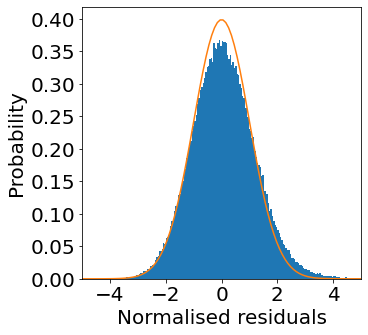

Convergence reached!
--- Finished kernel and background fit in 3.9058685302734375 seconds ---
Parameter containing:
tensor([[ 2.7504e+03, -7.3356e+01, -7.3221e+01,  9.8590e+01,  2.2942e+02,
          5.4711e+02,  1.0507e+00]], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9287, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2750.43798828125
Ignoring read noise...
Sum abs(norm_resids): 221308.32669779012

Number of masked pixels: 912.0


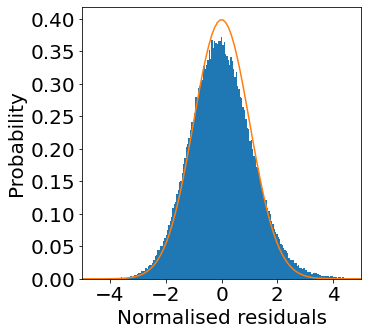

Decreasing SD learning rate to default for Adam: 1e-3
Convergence reached!
--- Finished kernel and background fit in 4.085630655288696 seconds ---
Parameter containing:
tensor([[ 2.7504e+03, -7.3349e+01, -7.3210e+01,  9.8572e+01,  2.2941e+02,
          5.4711e+02,  1.0729e+00]], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9286, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2750.43798828125
Photometric Scale Factor: 0.92859674
Converged in 3 iterations
--- Finished in a total of 17.867347717285156 seconds ---
SNR: 910.1395899228798
Image 12 of 158
FWHM: 8.330184880898496
N images: 1200.0
Aligning flat with (xs, ys) shifts: 0 8

Sample: 0
Not subtracting sky prior to kernel solution
Ignoring read noise...
--- Time to move data onto GPU: 0.0011889934539794922 ---
Switching to Qausi-Newton step
Convergence reached!
--- Finished kernel and background fit in 3.6381309032440186 seconds ---
Parameter containing:
tensor([[2630.5334,  -17.3669,  -33.2867, -136.7063,  -84.4

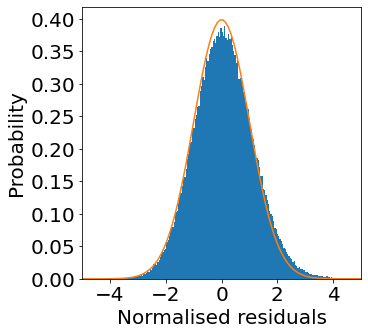

Switching to Qausi-Newton step
Convergence reached!
--- Finished kernel and background fit in 3.0239126682281494 seconds ---
Parameter containing:
tensor([[2645.4436,  -18.1078,  -41.6153,  -98.3221,  -29.3305, -269.3383,
         -306.1748]], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.8952, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2645.443603515625
Ignoring read noise...
Sum abs(norm_resids): 202171.38616214436

Number of masked pixels: 515.0


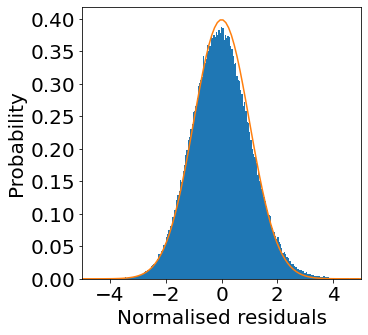

Decreasing SD learning rate to default for Adam: 1e-3
Switching to Qausi-Newton step
Convergence reached!
--- Finished kernel and background fit in 1.607595682144165 seconds ---
Parameter containing:
tensor([[2645.4448,  -18.1109,  -41.6155,  -98.3220,  -29.3299, -269.3374,
         -306.1747]], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.8951, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2645.44482421875
Photometric Scale Factor: 0.8950768
Converged in 3 iterations
--- Finished in a total of 12.51207971572876 seconds ---
SNR: 907.0893255256952
Image 13 of 158
FWHM: 8.519200254253198
N images: 1200.0
Aligning flat with (xs, ys) shifts: 3 0

Sample: 0
Not subtracting sky prior to kernel solution
Ignoring read noise...
--- Time to move data onto GPU: 0.0011115074157714844 ---
Switching to Qausi-Newton step
Convergence reached!
--- Finished kernel and background fit in 3.3869669437408447 seconds ---
Parameter containing:
tensor([[2902.4902, -126.1968, -132.7448,  1

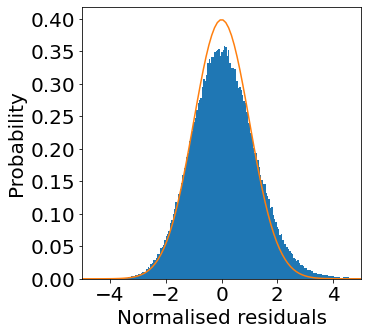

Convergence reached!
--- Finished kernel and background fit in 3.9211034774780273 seconds ---
Parameter containing:
tensor([[2914.9021, -125.3408, -145.9450,  206.7173,  457.3330,  880.6054,
          751.7865]], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9744, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2914.902099609375
Ignoring read noise...
Sum abs(norm_resids): 222742.25930571934

Number of masked pixels: 793.0


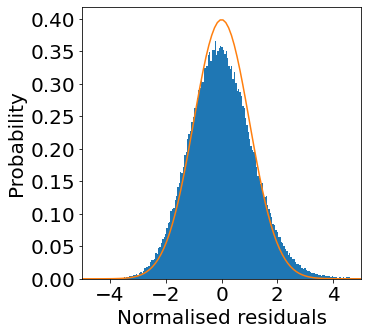

Decreasing SD learning rate to default for Adam: 1e-3
Switching to Qausi-Newton step
Convergence reached!
--- Finished kernel and background fit in 1.893519639968872 seconds ---
Parameter containing:
tensor([[2914.9038, -125.3369, -145.9447,  206.7158,  457.3347,  880.6079,
          751.7869]], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9744, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 2914.90380859375
Photometric Scale Factor: 0.9743967
Converged in 3 iterations
--- Finished in a total of 14.499728202819824 seconds ---
SNR: 922.1896863928056
Image 14 of 158
FWHM: 8.224922616031238
N images: 1200.0
Aligning flat with (xs, ys) shifts: 6 7

Sample: 0
Not subtracting sky prior to kernel solution
Ignoring read noise...
--- Time to move data onto GPU: 0.0014636516571044922 ---
Switching to Qausi-Newton step
Convergence reached!
--- Finished kernel and background fit in 3.1879918575286865 seconds ---
Parameter containing:
tensor([[2641.6501,  -19.9765,   60.1205, -

KeyboardInterrupt: ignored

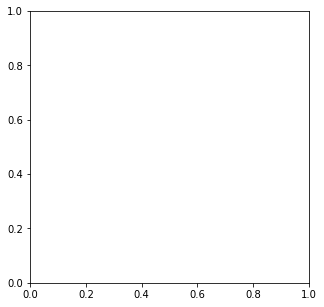

In [ ]:
## run this cell once to load gpu, then run again for actual test
## gpu overhead associated with first loading it will screw with the
## actual solutiontimes for the very first image

# define function to return fit quality metrics
def metrics(M, I, noise_map, kernel_size, mask):
    
    # crop image edges to exlcude convolution artefacts
    M = M[kernel_size:M.shape[0]-kernel_size, kernel_size:M.shape[1]-kernel_size]
    I = I[kernel_size:I.shape[0]-kernel_size, kernel_size:I.shape[1]-kernel_size]
    noise_map = noise_map[kernel_size:noise_map.shape[0]-kernel_size, kernel_size:noise_map.shape[1]-kernel_size]
    mask = mask[kernel_size:mask.shape[0]-kernel_size, kernel_size:mask.shape[1]-kernel_size]
    
    # calculate metrics
    #x[~np.array(mask)]
    N_data = len(I[~mask].flatten())
    MFB = 1./(N_data) * np.sum((I - M)/noise_map)
    MFV = 1./(N_data - 1) * np.sum((((I - M)/noise_map) - MFB)**2)
    return MFB, MFV

# cutout stamp around position of selected stars
def make_stamp(image, pos, stamp_size):
    rad = np.int(stamp_size/2)
    x_centroid, y_centroid = pos[1], pos[0]
    x_max, x_min = x_centroid + rad, x_centroid - rad
    y_max, y_min = y_centroid + rad, y_centroid - rad
    stamp = image[x_min:x_max+1, y_min:y_max+1]
    return stamp

# cutout stamp around position of selected stars
def make_fit_cutout(image_stamp, c_size):
    centre = np.int(image_stamp.shape[0]/2)
    radius = np.int((c_size/2))
    cutout = image_stamp[centre - radius:centre + radius + 1, centre - radius:centre + radius + 1]
    return cutout

## sky subtract reference
ref -= np.median(ref)

## iterate through target images

#target_size = 100

times_to_kernel_solution = []
total_times = []
image_FWHMs = []
image_SNRs = []


start_time = time.time()

for i, image in enumerate(images):

    print('Image %d of %d' % (i, len(images)))
    print('FWHM:', FWHMs[i])
    print('N images:', N_images[i])

    file_name = fnames[i]
    xs, ys = shifts[:,1][np.where(shifts[:,0] == file_name)][0], shifts[:,2][np.where(shifts[:,0] == file_name)][0]
    print('Aligning flat with (xs, ys) shifts:',xs.astype(int), ys.astype(int))

    flat = shift(master_flat, (ys.astype(int),xs.astype(int)), cval=0.)
    flat = flat[crop:flat.shape[0]-crop, crop:flat.shape[1]-crop]

   
    ### PyTorchDIA ####
    kernel, B0, solve_times, total_time, bad_pixel_mask = PyTorchDIA_Newton.DIA(ref,
                                                            image,
                                                            flat, # flatfield
                                                            read_noise = 0.,
                                                            tot_im = N_images[i],
                                                            unweighted=False,
                                                            n_samples=1,
                                                            full_image=True,
                                                            display_stamps=False, 
                                                            sky_subtract = False,
                                                            iters=3,
                                                            ks = 19,
                                                            lr_kernel = 1e-2,
                                                            lr_B = 100,
                                                            SD_steps = 1000,
                                                            Newton_tol = 1e-6,
                                                            m = 10,
                                                            poly_degree=3,
                                                            fast=False,
                                                            tol = 1e-9,
                                                            alpha = 0., 
                                                            max_iterations = 5000,
                                                            fisher=False,
                                                            show_convergence_plots=False,
                                                            display_D=False,
                                                            k=5,
                                                            precision=3,
                                                            display_masked_stamps=True,
                                                            display_M=False,
                                                            display_kernel=False,
                                                            display_B = False)
    
    

    
    # SNR calculation
    # model
    model = convolve2d(ref, kernel, mode='same') + B0
    # pixel uncertanties
    sigma0 = 2.55 # read noise
    #N = 1200 # number of images
    N = N_images[i]
    gain_CCD = 25.8 # CCD gain
    gain_EM = 300. # EM gain
    G = gain_CCD / gain_EM # Total gain
    excess_noise_factor = 2 # EMCCD fudge factor
    shot_noise = model/(G*flat)
    read_noise = N*sigma0**2 / flat**2
    #var_model = excess_noise_factor*(shot_noise + read_noise)
    var_model = excess_noise_factor*shot_noise
    pixel_uncertanties = np.sqrt(var_model) # Noise Model

    #plt.imshow(pixel_uncertanties)
    #plt.colorbar()
    #plt.show()

    sky = np.median(image)
    SNR = np.sum(image - sky) / np.sqrt(np.sum(pixel_uncertanties**2))
    print('SNR:', SNR)

    # image parameter info
    image_FWHMs.append(FWHMs[i]) 
    image_SNRs.append(SNR)
    
    # time to solution
    total_times.append(total_time)

    

#print(len(MFBs), len(MFVs), len(Ps_normalised), len(norm_phot_resids))
#print('Total time:', time.time() - start_time)

Text(0, 0.5, 'Image SNR')

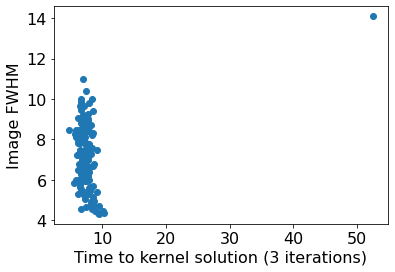

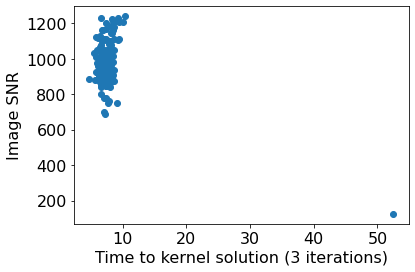

In [ ]:
## plots
fontsize = 16

plt.figure()
plt.scatter(total_times, image_FWHMs)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel('Time to kernel solution (3 iterations)', fontsize=fontsize)
plt.ylabel('Image FWHM', fontsize=fontsize)

plt.figure()
plt.scatter(total_times, image_SNRs)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel('Time to kernel solution (3 iterations)', fontsize=fontsize)
plt.ylabel('Image SNR', fontsize=fontsize)

In [ ]:
# other metrics info
print(len(total_times), len(image_FWHMs), len(image_SNRs))
print('Median solution time:', np.median(total_times))
print('Median FWHM:', np.median(image_FWHMs))
print('Median SNR:', np.median(image_SNRs))


158 158 158
Median solution time: 2.966955542564392
Median FWHM: 7.478626311636683
Median SNR: 261.7448


In [ ]:
out = np.vstack((total_times, image_FWHMs, image_SNRs)).T
print(out.shape)
np.savetxt(os.path.join(path,'performance_data_112x112_25x25_no_read_noise.txt'), out)

(158, 3)


In [ ]:
    '''
    ### pyDANDIA ###
    pyDANDIA_start = time.time()

    ss = 19

    mask = np.zeros(image.shape)


    for iters in range(0, 3):
        
        # pixel uncertanties
        sigma0 = 2.55 # read noise
        N = N_images[i] # number of images
        gain_CCD = 25.8 # CCD gain
        gain_EM = 300. # EM gain
        G = gain_CCD / gain_EM # Total gain
        excess_noise_factor = 2 # EMCCD fudge factor
        if iters == 0:
            shot_noise = image/(G*flat)
        else:
            shot_noise = model/(G*flat)   
        read_noise = N*sigma0**2 / flat**2
        var_model = excess_noise_factor*(shot_noise + read_noise)
        pixel_uncertanties = np.sqrt(var_model) 
        
        # Noise Model
        weights = 1./var_model
        # mask outliers
        weights[np.where(mask == 1)] = 1e-198
        print('\nMasked pixels (pyDANDIA):', np.sum(mask))
        print('\npyDANDIA solution, iter %d' % iters)
        ext_ref = extend_image(ref, ss)
        ext_imag = extend_image(image, ss)
        ext_weights = extend_image(weights, ss)

        U, b = construct_kernel_and_matrices(ss, ext_ref, ext_imag, ext_weights)
        kernel, B0 = lstsq_solution(ext_ref, ext_imag, U, b, ss)
        print('P:', np.sum(kernel))
        print('B0:', B0)
        start_conv2d = time.time()
        model = convolve2d(ref, kernel, mode='same') + B0
        print('Conv2d time:', time.time() - start_conv2d)
        print('weights shape:', weights.shape)
        print('image shape:', image.shape)
        print('model:', model.shape)
        norm_resids = np.sqrt(weights)*(image - model)
        mask[np.where(np.abs(norm_resids)>1e99)] = 1
        
        print('Sum abs(norm_resids):', np.sum(np.abs(norm_resids)))
        '''
        '''
        plt.figure(figsize=(5,5))
        plt.hist(norm_resids.flatten(), bins='auto', density=True)
        #x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
        x = np.linspace(-5, 5, 100)
        plt.plot(x, norm.pdf(x, 0, 1))
        plt.xlim(-5, 5)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        plt.xlabel('Normalised residuals', fontsize=20)
        plt.ylabel('Probability', fontsize=20)
        #plt.savefig(os.path.join(path, 'NormalisedResids.png'), bbox_inches='tight', overwrite=True)
        plt.show()
        '''
        '''
    # solution time
    #times_to_kernel_solution.append(solve_times)
    total_time = time.time() - pyDANDIA_start
    total_times.append(total_time)
    print('pyDANDIA time:', total_time)

    '''